# 1. Import needed libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
from zipfile import ZipFile
kaggle_config_path = '/content/kaggle.json'

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 90% 134M/149M [00:00<00:00, 186MB/s]
100% 149M/149M [00:00<00:00, 179MB/s]


In [ ]:
with ZipFile('/content/brain-tumor-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Brain tumor')

# 2. Preprocessing

## 2.1 Load data

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:

tr_df = train_df('/content/Brain tumor/Training')

In [ ]:
tr_df

,Class Path,Class
0,/content/Brain tumor/Training/notumor/Tr-no_15...,notumor
1,/content/Brain tumor/Training/notumor/Tr-no_08...,notumor
2,/content/Brain tumor/Training/notumor/Tr-no_12...,notumor
3,/content/Brain tumor/Training/notumor/Tr-no_14...,notumor
4,/content/Brain tumor/Training/notumor/Tr-no_02...,notumor
...,...,...
5707,/content/Brain tumor/Training/pituitary/Tr-pi_...,pituitary
5708,/content/Brain tumor/Training/pituitary/Tr-pi_...,pituitary
5709,/content/Brain tumor/Training/pituitary/Tr-pi_...,pituitary
5710,/content/Brain tumor/Training/pituitary/Tr-pi_...,pituitary


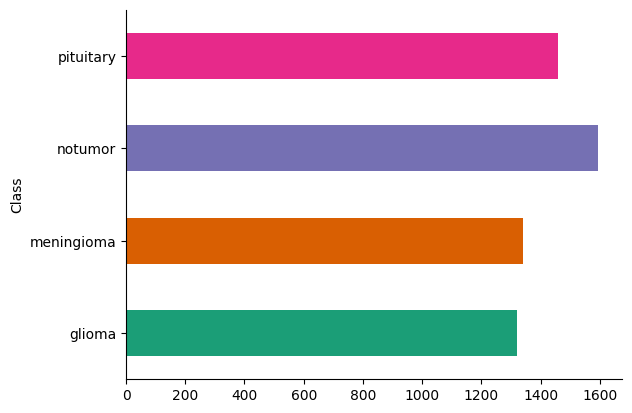

In [ ]:
# @title Class

from matplotlib import pyplot as plt
import seaborn as sns
tr_df.groupby('Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
ts_df = test_df('/content/Brain tumor/Testing')

In [ ]:
ts_df

,Class Path,Class
0,/content/Brain tumor/Testing/notumor/Te-no_009...,notumor
1,/content/Brain tumor/Testing/notumor/Te-no_025...,notumor
2,/content/Brain tumor/Testing/notumor/Te-no_036...,notumor
3,/content/Brain tumor/Testing/notumor/Te-no_007...,notumor
4,/content/Brain tumor/Testing/notumor/Te-no_016...,notumor
...,...,...
1306,/content/Brain tumor/Testing/pituitary/Te-pi_0...,pituitary
1307,/content/Brain tumor/Testing/pituitary/Te-piTr...,pituitary
1308,/content/Brain tumor/Testing/pituitary/Te-pi_0...,pituitary
1309,/content/Brain tumor/Testing/pituitary/Te-pi_0...,pituitary


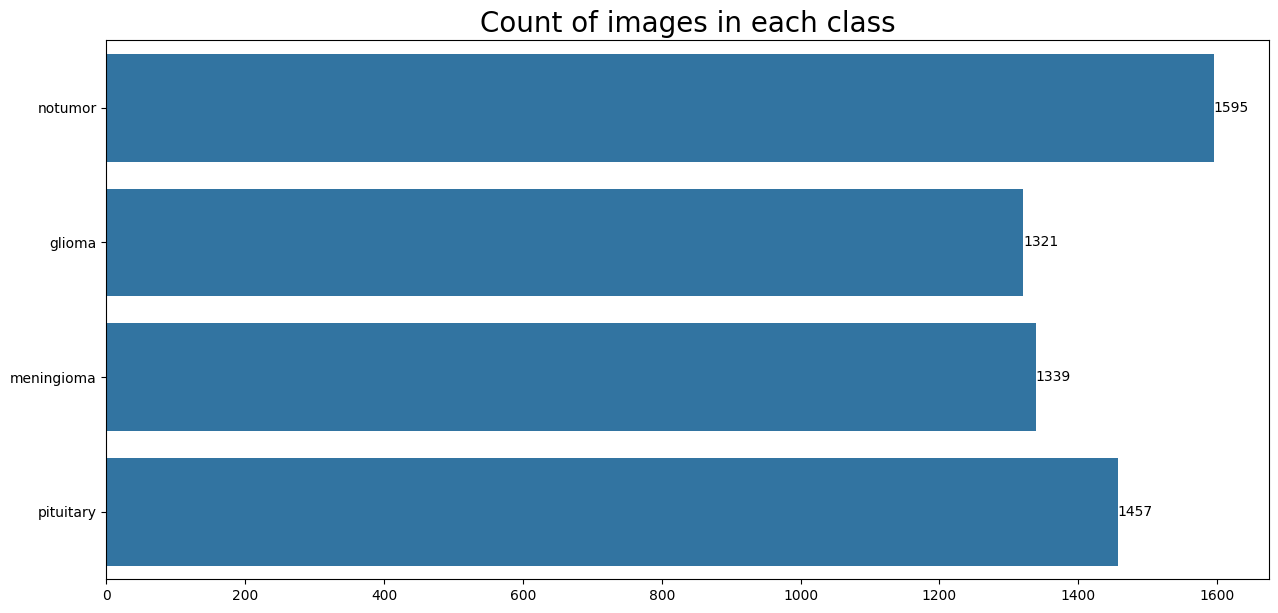

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

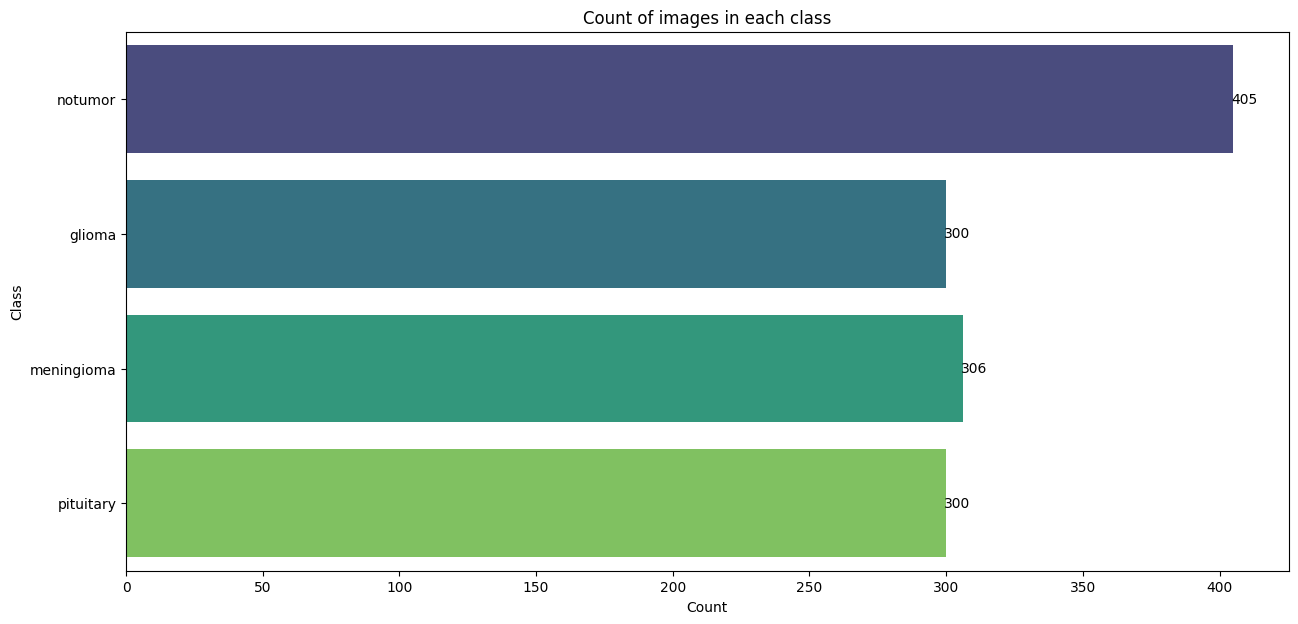

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='Count', ylabel='Class', title='Count of images in each class')

# Function to add count labels on top of each bar
def add_count_labels(plot, field):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center', fontsize=10, color='black', xytext=(8, 0),
                    textcoords='offset points')

add_count_labels(ax, ts_df['Class'])

plt.show()


## 2.2 Split data into train, test, valid

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
valid_df

,Class Path,Class
691,/content/Brain tumor/Testing/glioma/Te-gl_0182...,glioma
723,/content/Brain tumor/Testing/meningioma/Te-me_...,meningioma
1072,/content/Brain tumor/Testing/pituitary/Te-pi_0...,pituitary
778,/content/Brain tumor/Testing/meningioma/Te-me_...,meningioma
514,/content/Brain tumor/Testing/glioma/Te-gl_0235...,glioma
...,...,...
464,/content/Brain tumor/Testing/glioma/Te-gl_0020...,glioma
254,/content/Brain tumor/Testing/notumor/Te-no_031...,notumor
678,/content/Brain tumor/Testing/glioma/Te-gl_0043...,glioma
899,/content/Brain tumor/Testing/meningioma/Te-me_...,meningioma


## 2.3 Data preprocessing

In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

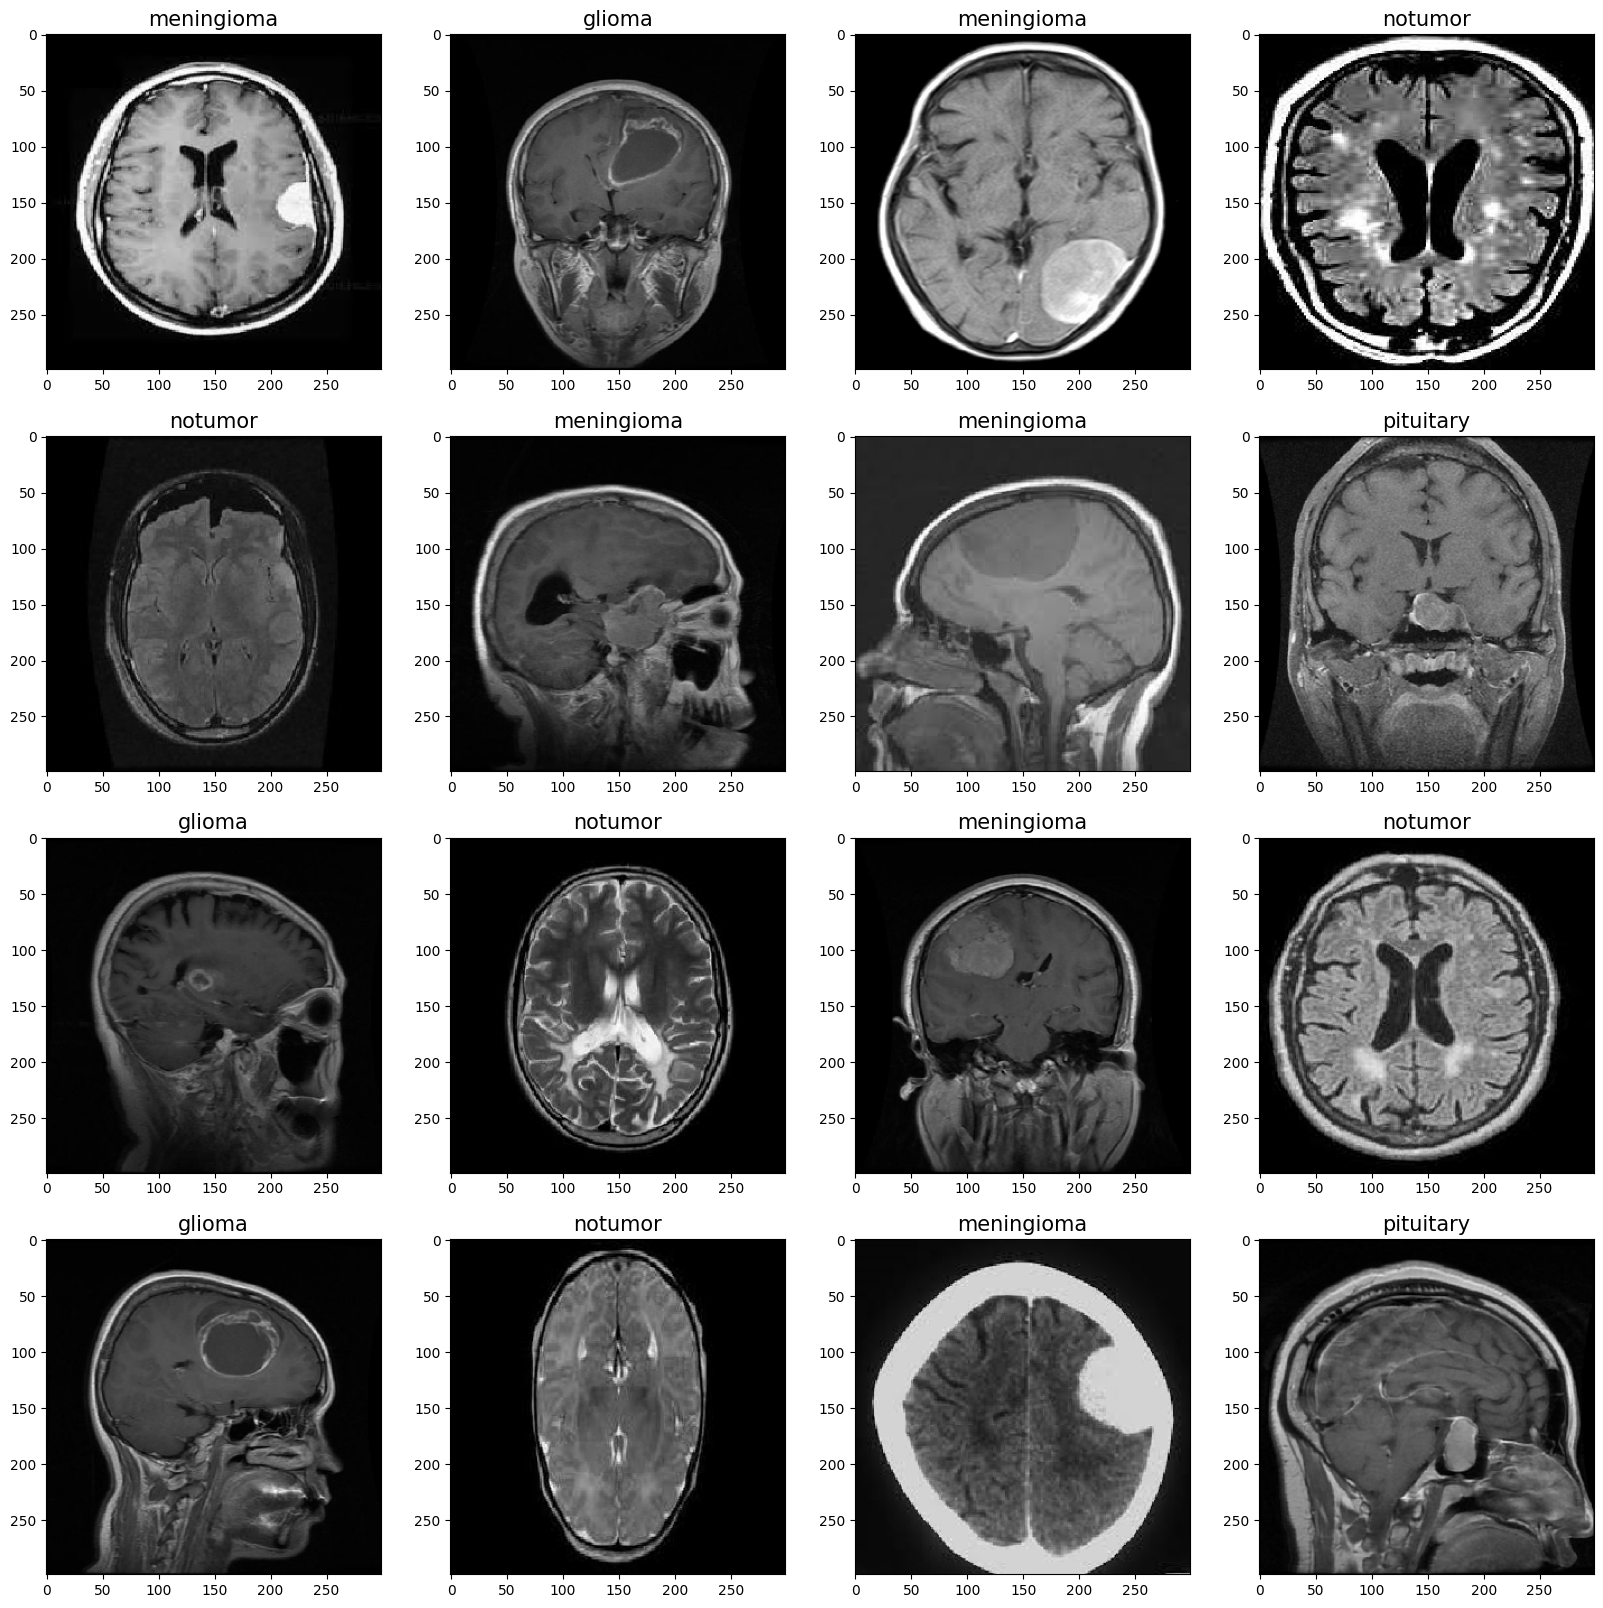

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

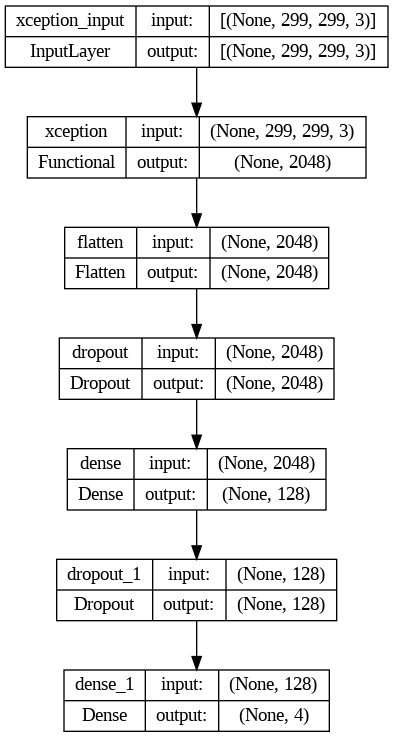

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [ ]:
hist = model.fit(tr_gen,
                 epochs=15,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/15
179/179 [==============================] - 199s 904ms/step - loss: 0.3440 - accuracy: 0.8790 - precision: 0.9267 - recall: 0.8339 - val_loss: 0.2325 - val_accuracy: 0.9084 - val_precision: 0.9140 - val_recall: 0.9084
Epoch 2/15
179/179 [==============================] - 154s 861ms/step - loss: 0.0683 - accuracy: 0.9788 - precision: 0.9807 - recall: 0.9776 - val_loss: 0.0489 - val_accuracy: 0.9832 - val_precision: 0.9847 - val_recall: 0.9832
Epoch 3/15
179/179 [==============================] - 156s 870ms/step - loss: 0.0310 - accuracy: 0.9900 - precision: 0.9911 - recall: 0.9895 - val_loss: 0.0363 - val_accuracy: 0.9863 - val_precision: 0.9863 - val_recall: 0.9863
Epoch 4/15
179/179 [==============================] - 156s 870ms/step - loss: 0.0184 - accuracy: 0.9944 - precision: 0.9946 - recall: 0.9944 - val_loss: 0.0211 - val_accuracy: 0.9924 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 5/15
179/179 [==============================] - 154s 858ms/step - loss: 0.0129 - a

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

## 4.1 Visualize model performance

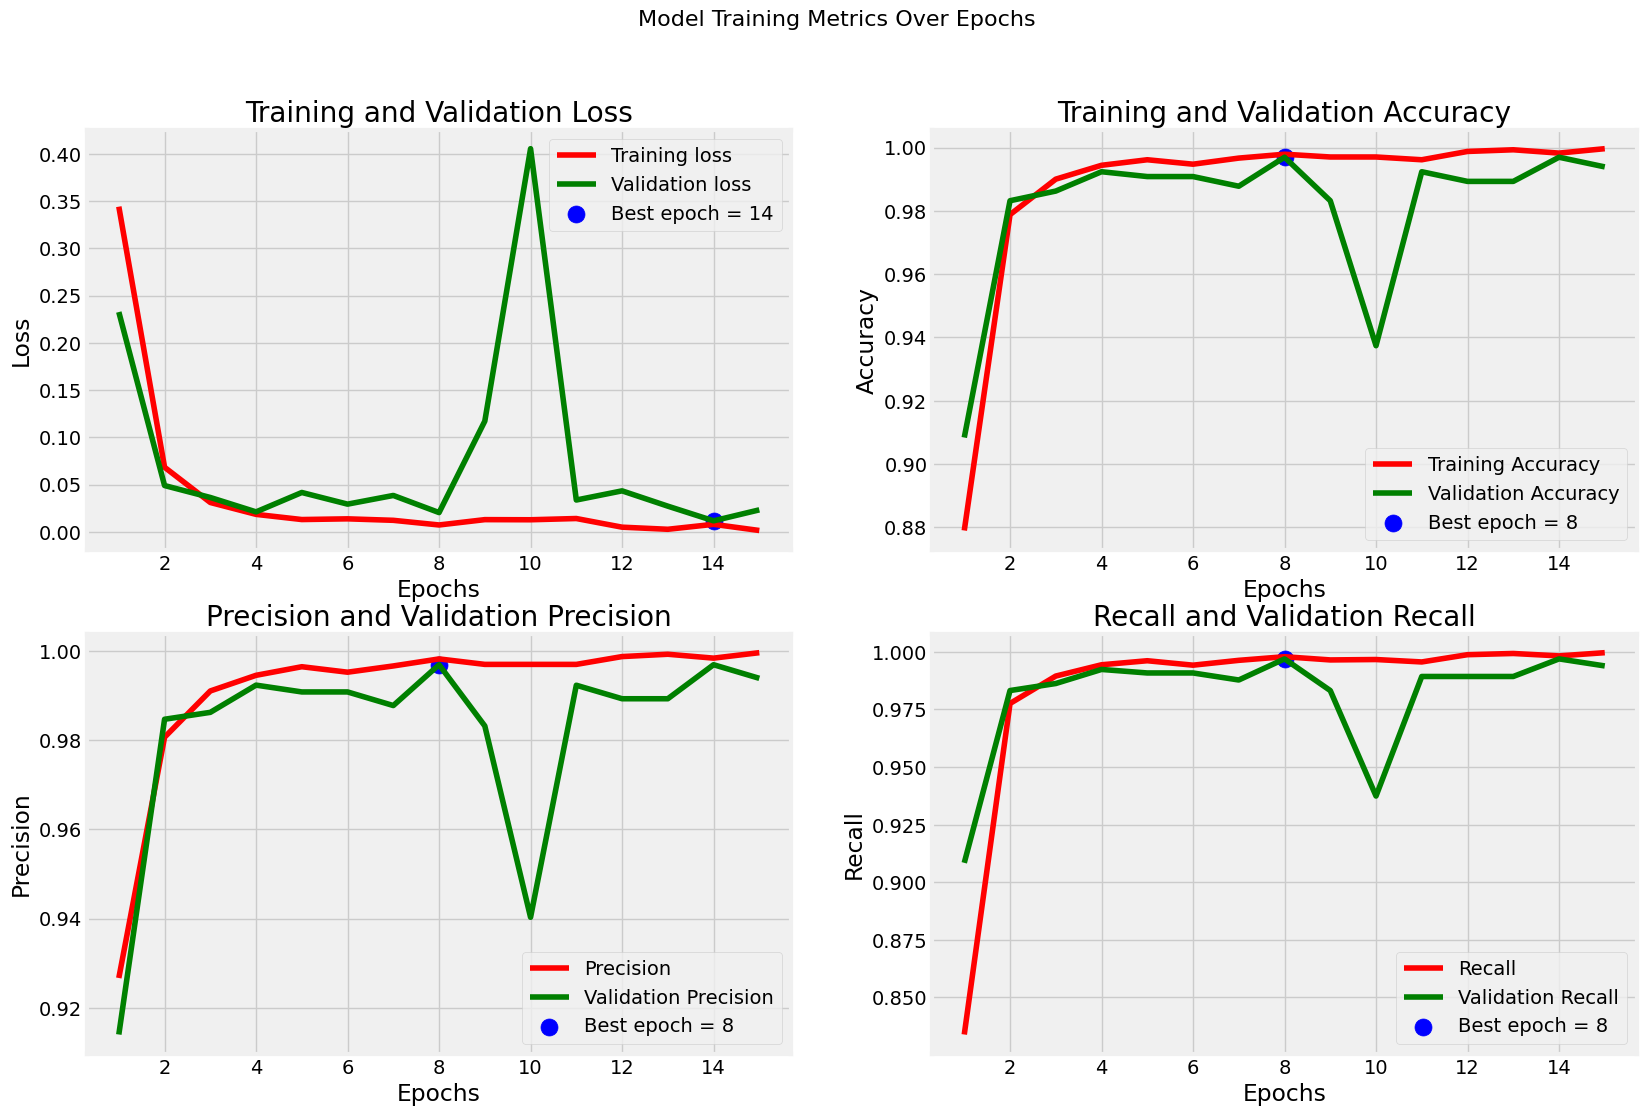

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


41/41 [==============================] - 5s 117ms/step - loss: 0.0346 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909
Train Loss: 0.0000
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.0193
Validation Accuracy: 99.39%
--------------------
Test Loss: 0.0346
Test Accuracy: 99.09%


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 6s 114ms/step


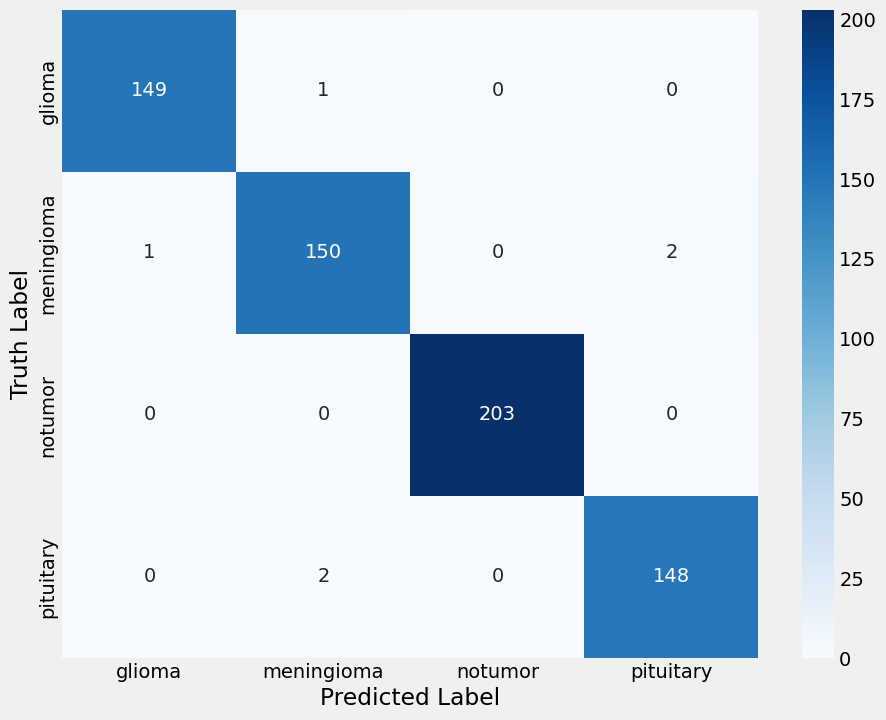

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.98      0.98      0.98       153
           2       1.00      1.00      1.00       203
           3       0.99      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



## 5.2 Testing

In [ ]:
# Saving the model
model.save('/content/drive/MyDrive/RAGHU/my_model.h5')

In [ ]:
# Loading the saved model
from tensorflow.keras.models import load_model
saved_model = load_model('/content/drive/MyDrive/RAGHU/my_model.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load your model
model = tf.keras.models.load_model('/content/drive/MyDrive/RAGHU/my_model.h5')

# Define a function to preprocess input images
def preprocess_image(image_path, target_size=(299, 299)):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Convert grayscale to RGB
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)
    return img_array




In [ ]:
def predict(img_path, saved_model):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # Preprocess the image
    img = preprocess_image(img_path)

    # Load the model
    model = tf.keras.models.load_model(saved_model)

    # Make predictions
    predictions = model.predict(img)

    # Get class labels
    label = list(class_dict.keys())

    # Plot the image
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    plt.subplot(2, 1, 1)
    plt.imshow(img)

    # Plot the predicted probabilities
    plt.subplot(2, 1, 2)
    bars = plt.barh(label, predictions[0])
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    plt.show()



1/1 [==============================] - 3s 3s/step


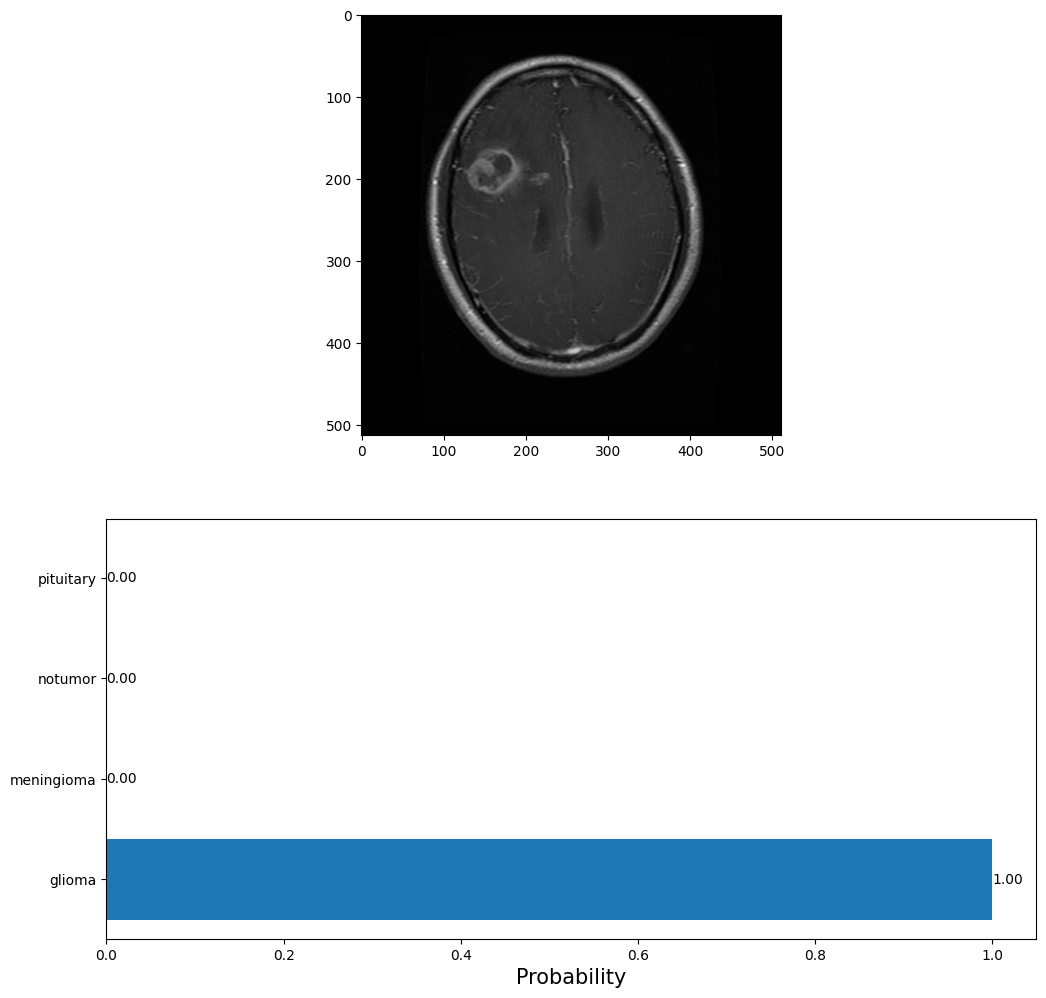

In [ ]:
predict('/content/Brain tumor/Testing/glioma/Te-gl_0027.jpg', '/content/drive/MyDrive/RAGHU/my_model.h5')

1/1 [==============================] - 3s 3s/step


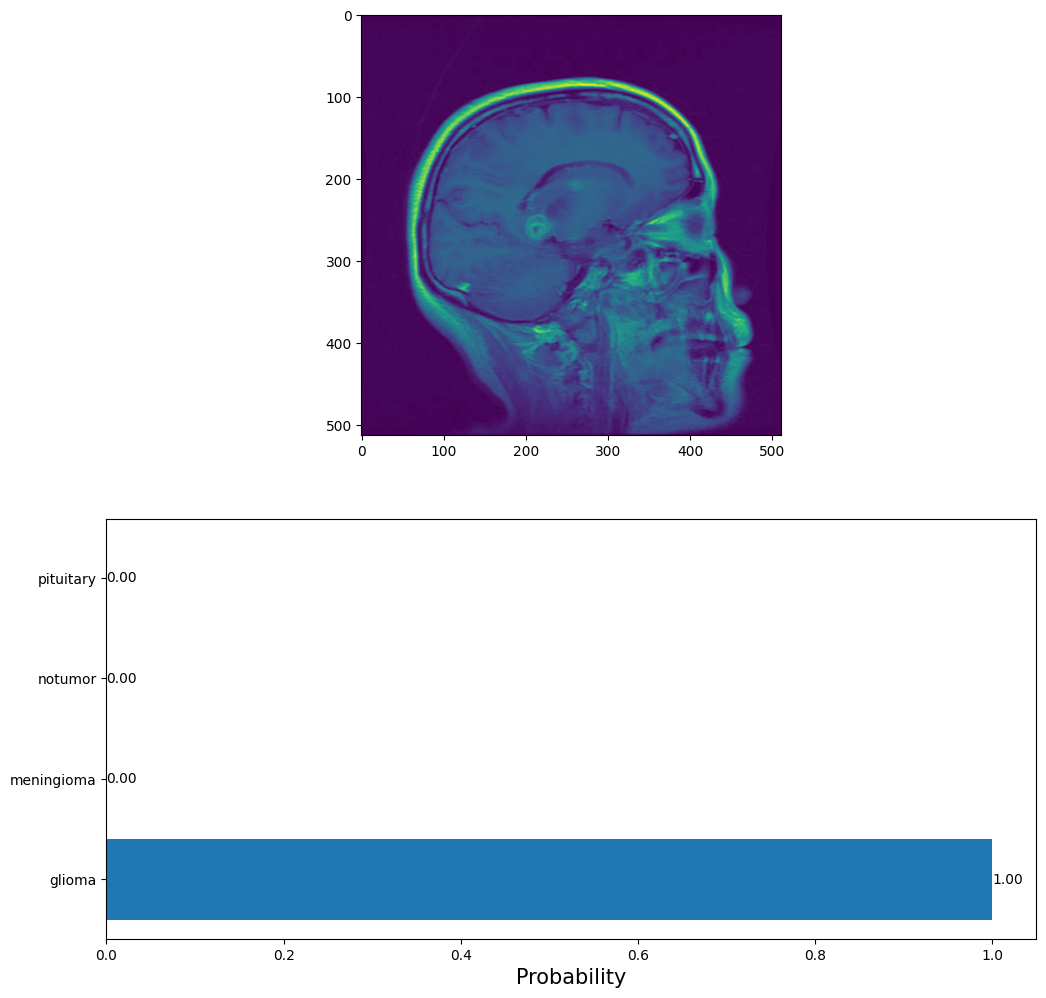

In [ ]:
predict('/content/Brain tumor/Testing/glioma/Te-gl_0242.jpg', '/content/drive/MyDrive/RAGHU/my_model.h5')

1/1 [==============================] - 2s 2s/step


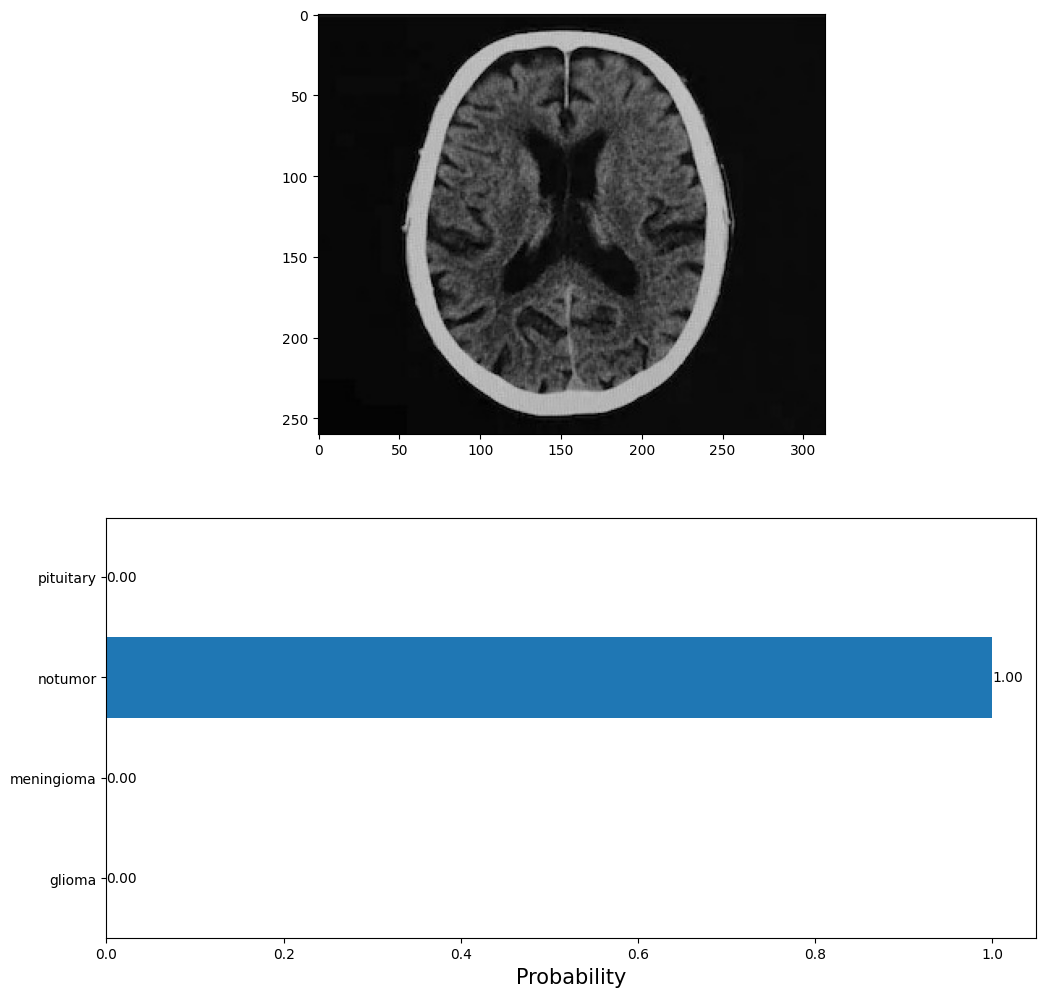

In [ ]:
predict('/content/Brain tumor/Testing/notumor/Te-noTr_0005.jpg','/content/drive/MyDrive/RAGHU/my_model.h5')

1/1 [==============================] - 1s 1s/step


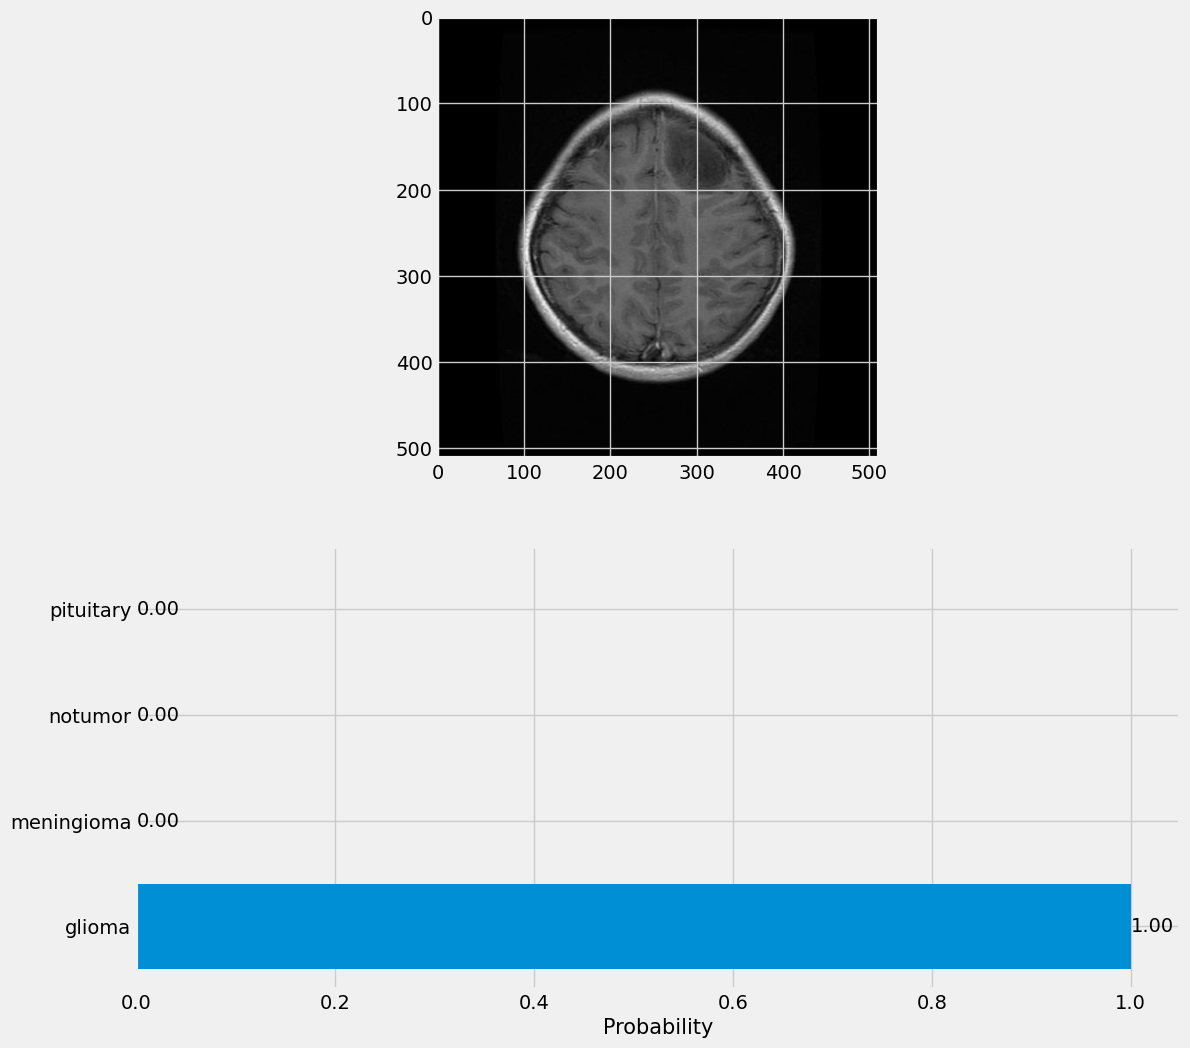

In [ ]:
predict('/content/Brain tumor/Testing/glioma/Te-glTr_0005.jpg','/content/drive/MyDrive/RAGHU/my_model.h5')

1/1 [==============================] - 1s 745ms/step


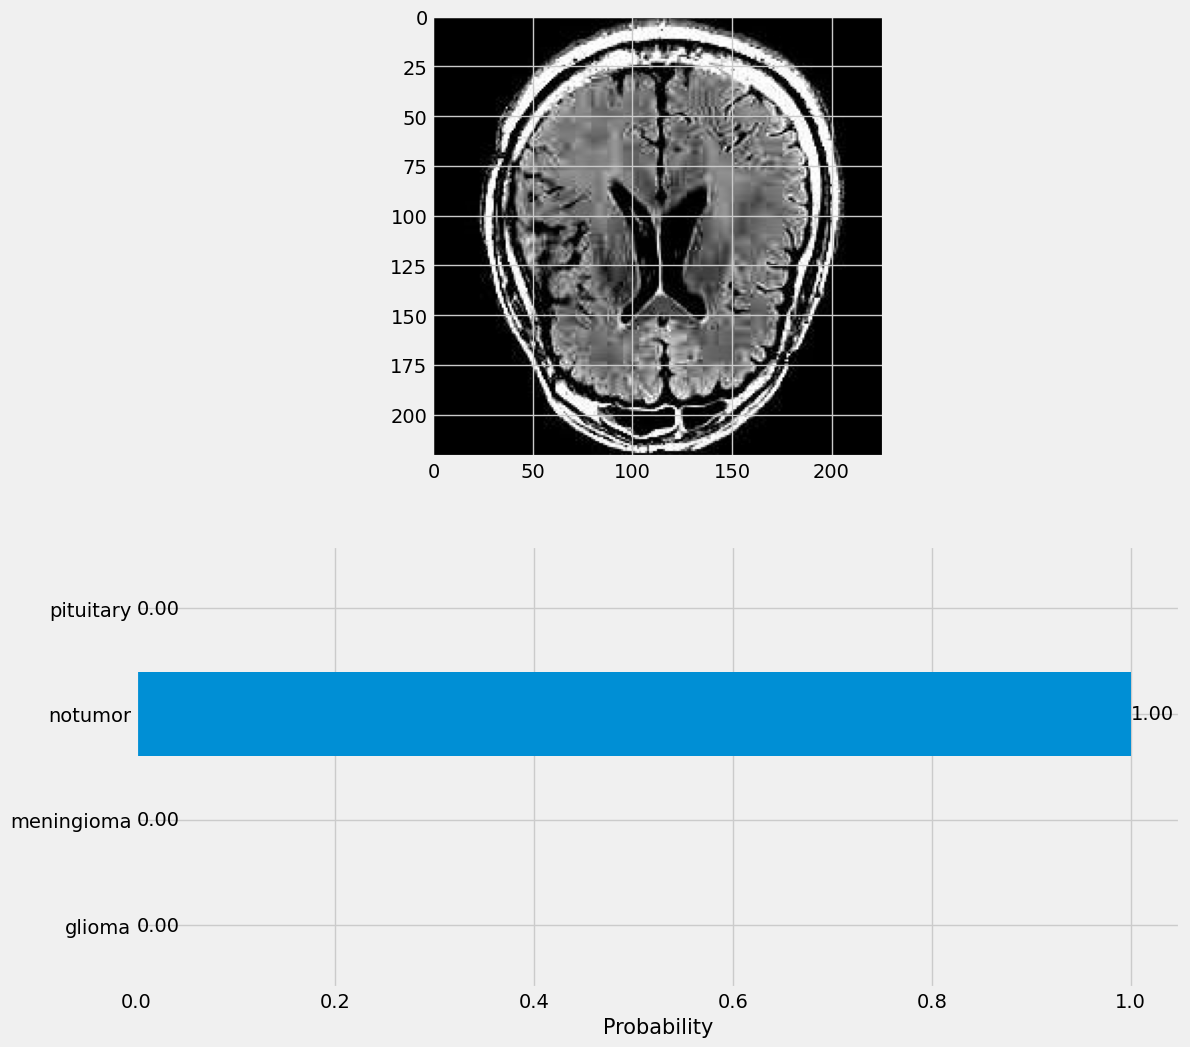

In [ ]:
predict('/content/Brain tumor/Testing/notumor/Te-no_0207.jpg','/content/drive/MyDrive/RAGHU/my_model.h5')

1/1 [==============================] - 1s 767ms/step


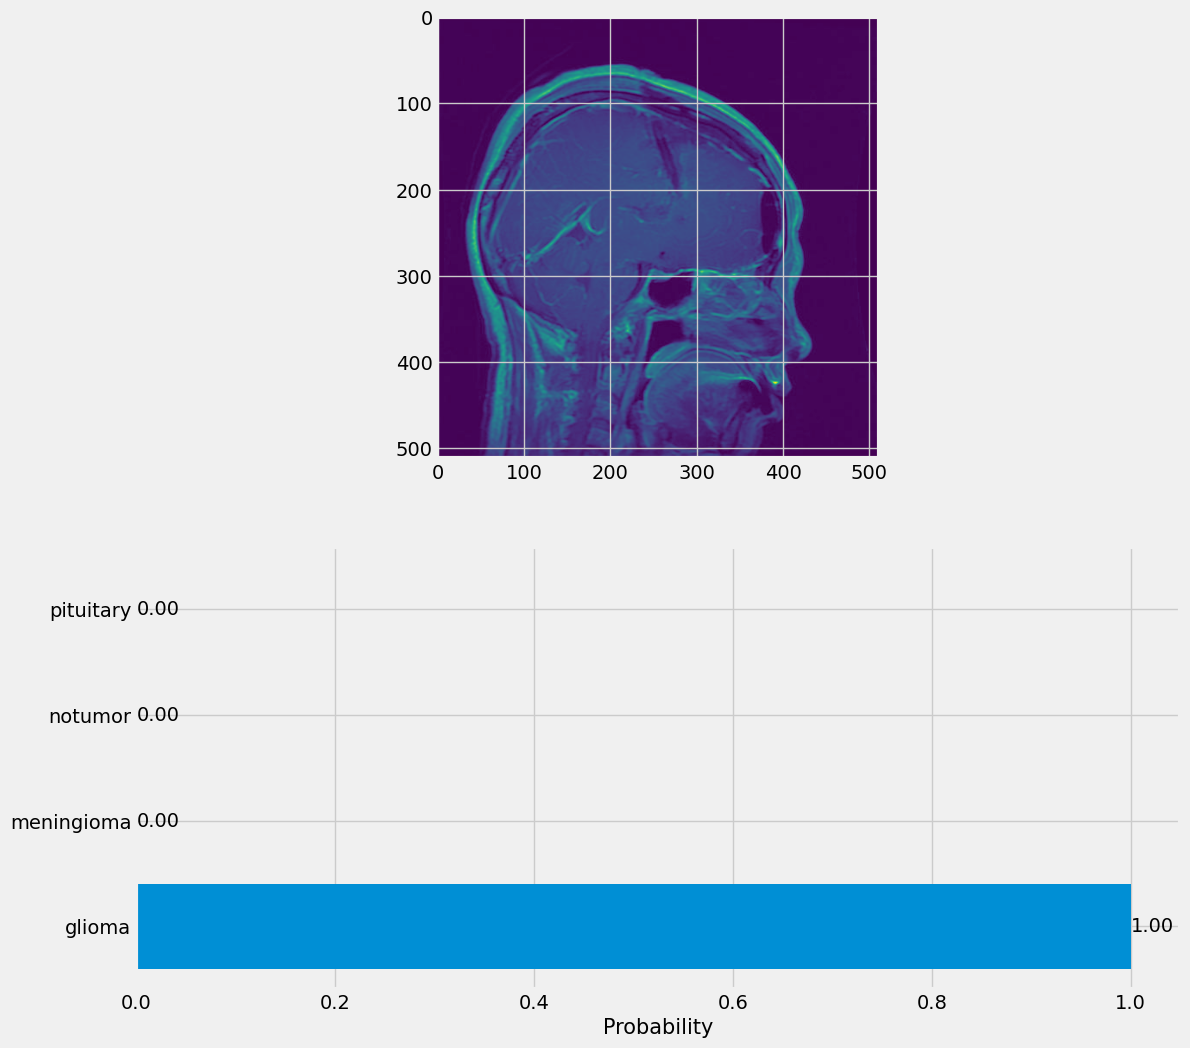

In [ ]:
predict('/content/Brain tumor/Testing/glioma/Te-gl_0180.jpg','/content/drive/MyDrive/RAGHU/my_model.h5')